# Numerical Exercises 10

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

csv_path = "./CSV/"

In this exercise I will extend the code from Lab9 to perform parallel runs and, in a second moment, I will let these runs interact via *migrations*. 

## 10.1

As I said in Lab9, any genetic algorithm does not progressively refine the optimization parameter of a single instance of the problem, but rather searches within multiple possible solution the best ones, from which it generates a new set of hopefully better solutions. It immediately follows that such algorithms are intrinsically parallelizable. 

To apply parallelization to the TSP code I used the MPI library, which allows to create different instances (nodes) of the same program with different inputs (SPMD model) and handle the communication between them. After including the library and slightly updating the code to accommodate the necessary MPI functions, I run the TSP problem, with cities given by the $50$ american capitals (their position have been read from an externally provided file), on $5$ different nodes. During this process I also had to tune again the genetic algorithm parameters in order to obtain a good solution and a reasonably-looking half-best and absolute best fit graph for this particular TSP. The final utilized parameters are:

- $M=1000$
- $N_{Gens}=500$
- $p_C=0.5$
- $p_M=0.15$
- $p=5.0$

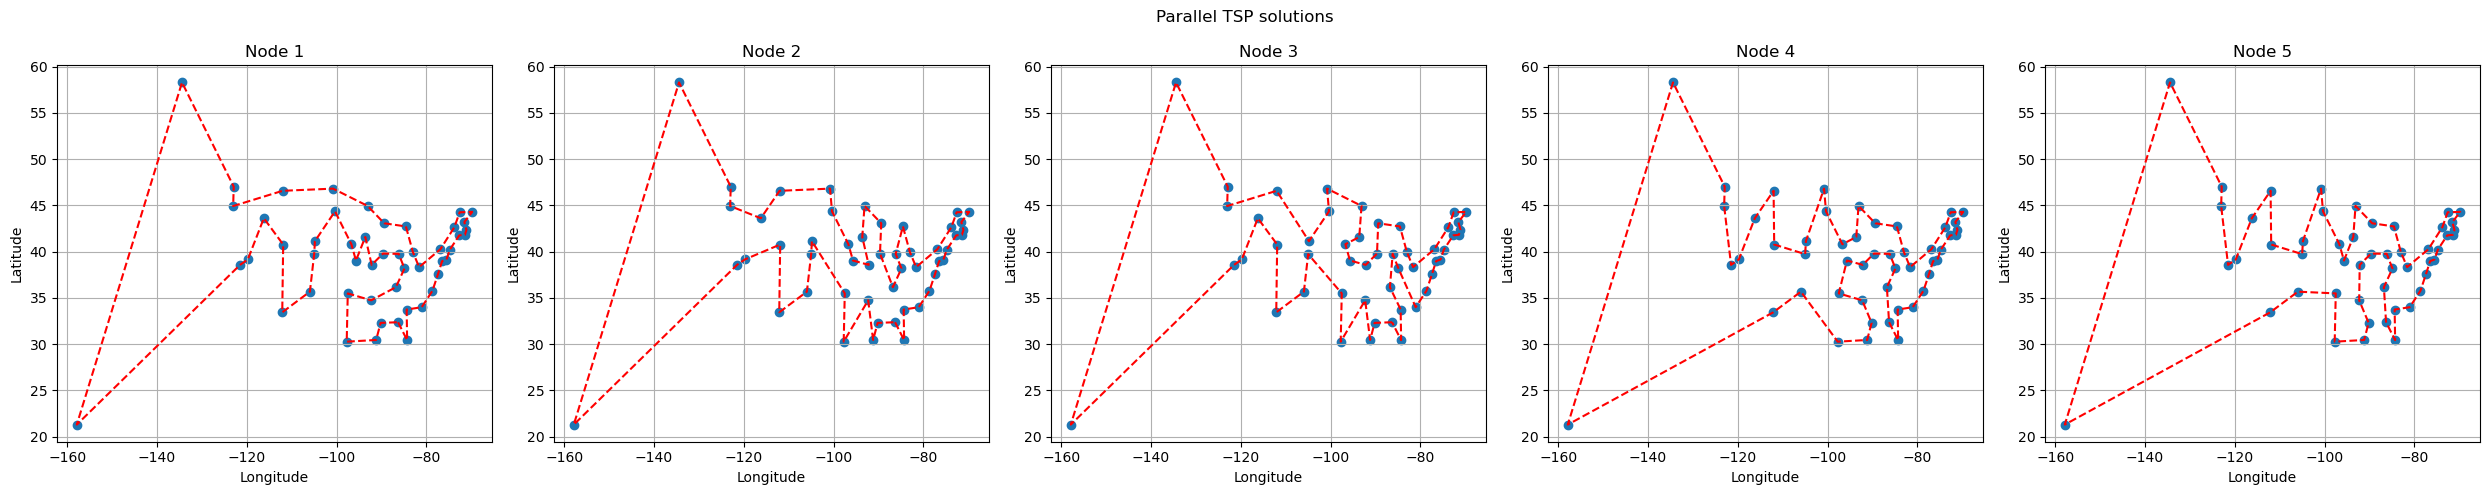

In [22]:
plt.figure().set_size_inches(25, 5)

for idx in range(5):

    plt.subplot(1, 5, idx + 1)

    filename = csv_path + "NoMigr/Ex10_1_Solution_" + str(idx) + ".csv"

    Cities = np.loadtxt(csv_path + "NoMigr/Ex10_1_Cities.csv", delimiter = ',')
    Cities_Coord = Cities[:, 1:]

    Path = np.loadtxt(filename, delimiter = ',')
    Path_Coord = []

    for i in Path:
        Path_Coord.append([Cities_Coord[int(i) - 1, 0], Cities_Coord[int(i) - 1, 1]])
    Path_Coord.append([Cities_Coord[0, 0], Cities_Coord[0, 1]])
    
    Path_Coord = np.asarray(Path_Coord)

    plt.scatter(Cities_Coord[:,0], Cities_Coord[:,1])
    plt.plot(Path_Coord[:,0], Path_Coord[:,1], 'r--')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Node {}".format(idx + 1))
    plt.grid(True)

plt.suptitle("Parallel TSP solutions")
plt.tight_layout()
plt.show()

Node 1 fit: 278.081
Node 2 fit: 272.306
Node 3 fit: 280.171
Node 4 fit: 274.191
Node 5 fit: 271.187


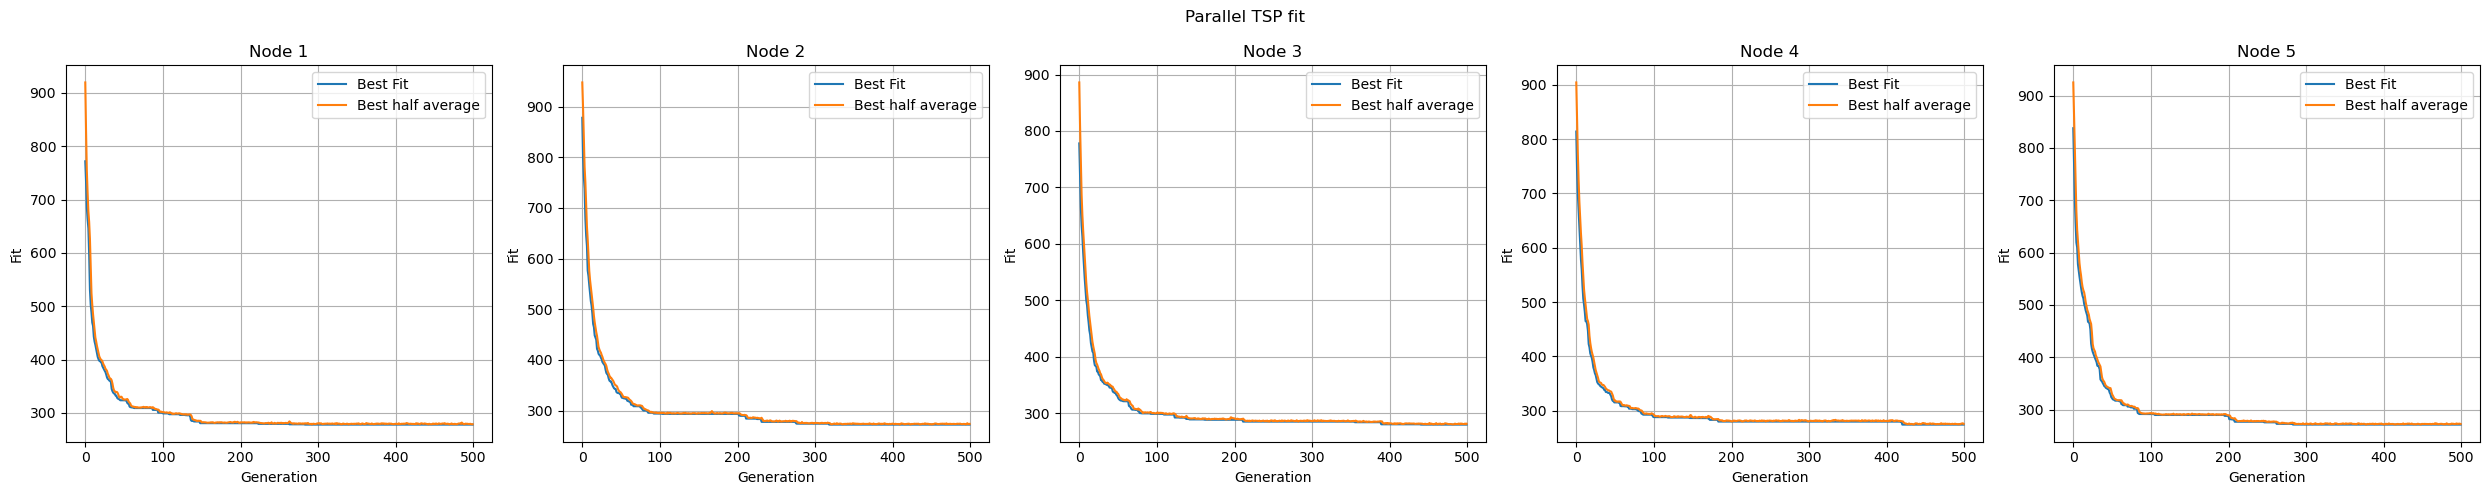

In [24]:
plt.figure().set_size_inches(25, 5)

for i in range(5):

    plt.subplot(1, 5, i + 1)

    filename = csv_path + "NoMigr/Ex10_1_Hist_" + str(i) + ".csv"

    Hist = np.loadtxt(filename, delimiter = ',')

    plt.plot(Hist[:,0], label = "Best Fit")
    plt.plot(Hist[:,1], label = "Best half average")
    plt.xlabel("Generation")
    plt.ylabel("Fit")
    plt.title("Node {}".format(i + 1))
    plt.grid(True)
    plt.legend()

    print("Node {} fit: {}".format(i + 1, Hist[-1,0]))

plt.suptitle("Parallel TSP fit")
plt.tight_layout()
plt.show()

As expected, the five nodes obtained five different solutions, since there is no interactions between them and their random number generators have been instantiated with different seeds.

## 10.2

I am now going to introduce an interaction, called *migration*, between the different nodes (each of which now represents a *continent*) in order to discover whether the exchange of information between them has a positive effect on the final result. These migrations consist in an exchange of the best-fitted individual of two continents and take place each $N_{Migr}$ generations; the implementation using MPI works as follows:

1. Each $N_{Migr}$ generations the first node (Node 0 in the code) randomly extract $\frac{N_{Nodes}}{2}$ couples, which represents two coupled continents that will exchange their best individuals. If $N_{Nodes}$ is odd one randomly selected node does not migrate.
2. The extracted couples are broadcasted to all nodes.
3. Each node exchange its best individual with the extracted second node.
4. The program execution in each node proceeds until the next migration. 

At first I used $N_{Migr} = 50$ but, after a couple of tests, I found out that lower values resulted in better results; this could be because if we allow the evolution in each node to proceed for a large number of generations we may have the following situation: 

- Node A has a very well-fitted best individuals
- Node B has a significantly worse best individuals

When Node A and Node B exchange their best chromosomes, in the next generation this may happen:

- Node A will have worse individuals than what it would without an exchange
- Node B will have surely better individuals but not better enough to have a significative impact. 

These problems could be resolved by further tweaking the algorithm parameters (for example by increasing the bias towards better individuals to help improvements in Node B), but, if we reduce $N_{Migr}$ we can have more similar best-fitted individuals between the nodes, thus partially solving the problem without the need of a complete recalibration. In the end I then chose this latter approach and set $N_{Migr} = 25$.

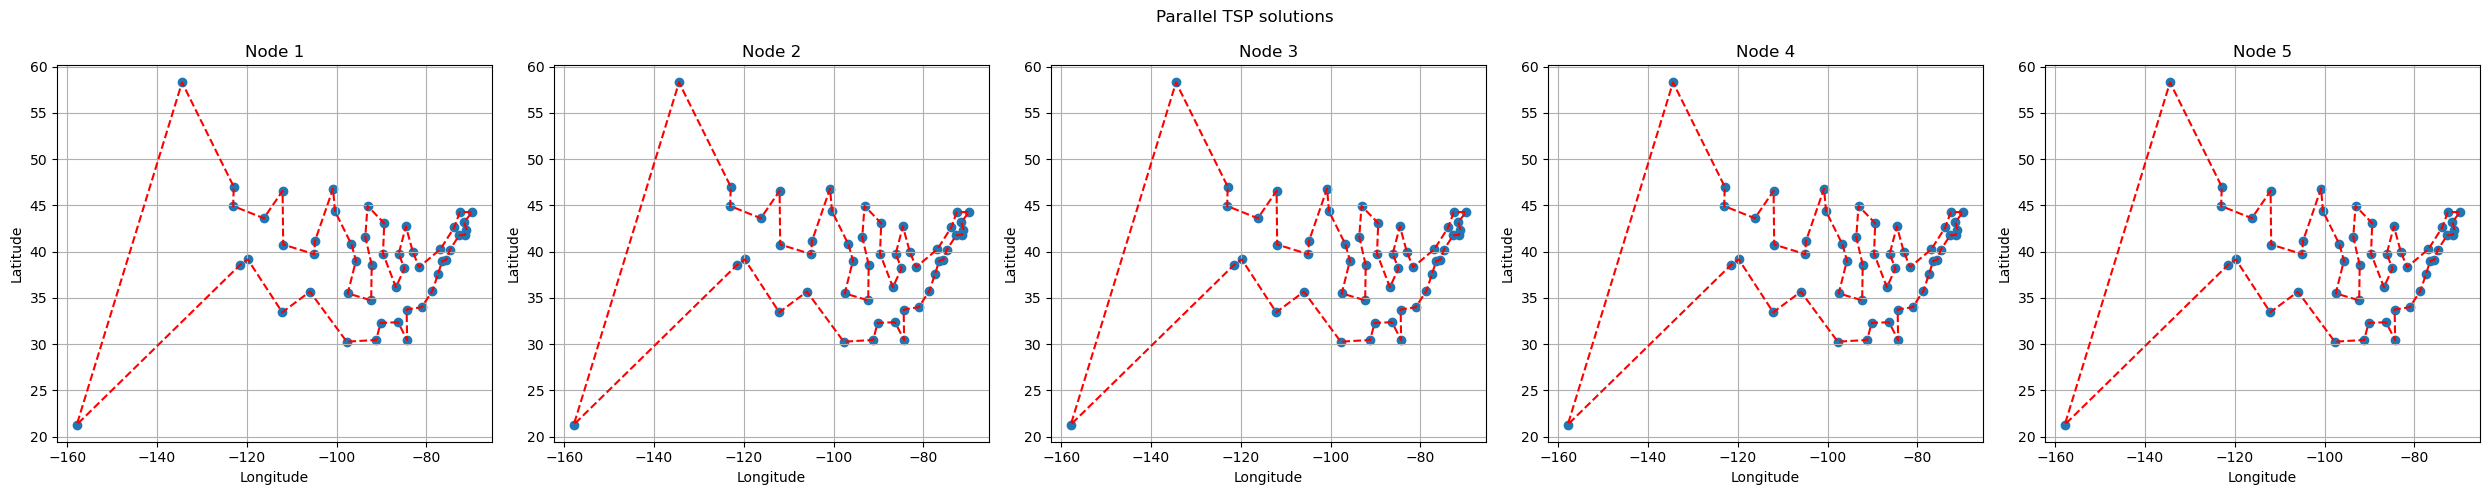

In [11]:
plt.figure().set_size_inches(25, 5)

for idx in range(5):

    plt.subplot(1, 5, idx + 1)

    filename = csv_path + "Migr/Ex10_1_Solution_" + str(idx) + ".csv"

    Cities = np.loadtxt(csv_path + "Migr/Ex10_1_Cities.csv", delimiter = ',')
    Cities_Coord = Cities[:, 1:]

    Path = np.loadtxt(filename, delimiter = ',')
    Path_Coord = []

    for i in Path:
        Path_Coord.append([Cities_Coord[int(i) - 1, 0], Cities_Coord[int(i) - 1, 1]])
    Path_Coord.append([Cities_Coord[0, 0], Cities_Coord[0, 1]])
    
    Path_Coord = np.asarray(Path_Coord)

    plt.scatter(Cities_Coord[:,0], Cities_Coord[:,1])
    plt.plot(Path_Coord[:,0], Path_Coord[:,1], 'r--')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Node {}".format(idx + 1))
    plt.grid(True)

plt.suptitle("Parallel TSP solutions")
plt.tight_layout()
plt.show()

Node 1 fit: 270.845
Node 2 fit: 270.845
Node 3 fit: 270.845
Node 4 fit: 270.845
Node 5 fit: 270.845


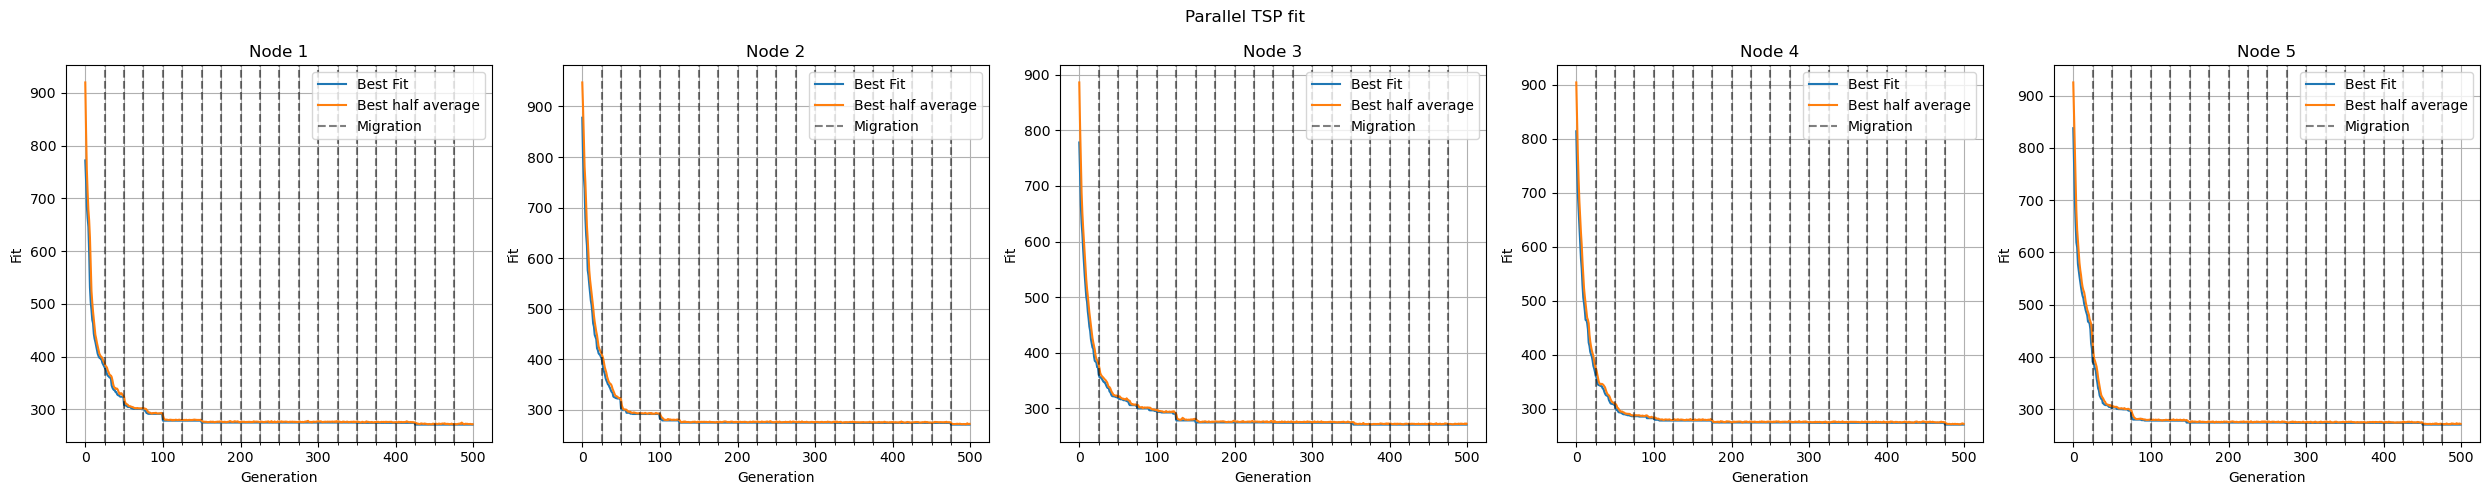

In [25]:
plt.figure().set_size_inches(25, 5)

for i in range(5):

    plt.subplot(1, 5, i + 1)

    filename = csv_path + "Migr/Ex10_1_Hist_" + str(i) + ".csv"

    Hist = np.loadtxt(filename, delimiter = ',')

    plt.plot(Hist[:,0], label = "Best Fit")
    plt.plot(Hist[:,1], label = "Best half average")

    plt.gca().set_xticks(range(0, 500, 25), minor = True)
    
    for migr_gen in range(25, 500, 25): 

        migr_label = None

        if migr_gen == 25:
            migr_label = "Migration"
        
        plt.axvline(migr_gen, c = "black", alpha = 0.5, ls = "--", label = migr_label)
    
    plt.xlabel("Generation")
    plt.ylabel("Fit")
    plt.title("Node {}".format(i + 1))
    plt.grid(which = 'both')
    plt.legend()

    print("Node {} fit: {}".format(i + 1, Hist[-1,0]))

plt.suptitle("Parallel TSP fit")
plt.tight_layout()
plt.show()

As we can see, the first result of the migration is to obtain an identical solution across each node (this also confirms my statement in which I claimed that a lower $N_{Migr}$ would lead to a more uniform result across nodes). If we look at the fit plots, we can also observe that, when a migration takes place, some node reduces their best fit (we in fact have a descending step in the curve); in the end this leads to a significantly better final result than the one I obtained without migration. 

As I final note, the fact that the steps in the fit curves are always descending suggests that the $p$ parameter and the diversity in each population have been correctly tweaked so that:

1. It is low enough to accept the reception of a better individual and efficiently use it to generate a new population.
2. It is high enough to absorb the reception of a worse individual by consistently discarding it in the crossover process. 